# Loan Data from Prosper 
## by Christian Altmoos

## Investigation Overview

The analysis of the Prosper Loan Dataset was executed to answer the following questions:

* Who is using Prosper? Basically which individuals, which professions, which part of the country, financial situation?

* Why is Prosper used? Is it related to rates, fees, or faster processing time?

* What is primarily influencing the interest rate? Is it related to scoring, income and history?

## Dataset Overview
This data set contains 113,937 loans with 81 variables on each investment, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others. The dataset contains so-called listings which either have been transformed to a loan or not. Partially funded loans are possible as well. My main overall interest might be why and who is becoming a so-called Prosper borrower and furthermore what is mainly influencing the interest rate. Interesting would be how the average Prosper rate is compared to the typical financial market.

In [5]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings

%matplotlib inline
warnings.filterwarnings("always")


# switch off warnings
import warnings
warnings.filterwarnings("ignore")

sb.set(style="whitegrid")
base_color = sb.color_palette()[0]


# load the csv
df=pd.read_csv('prosperLoanData.csv')

#################Do the whole preprocssing 
# harmonize and shrink the dataset based on the above mentioned rationales
# read the selected attributes
attr_2_be_del = pd.read_csv('Attributes_Not_Selected.csv')
# drop the columns not in favour
for attr in attr_2_be_del.Attributes:
    df.drop([attr], axis=1, inplace=True)
    # rename some colums with blanks 
for column in df:
    df.rename(index=str, columns={column: column.replace(' ', '')}, inplace=True)
for column in df:
    df.rename(index=str, columns={column: column.replace('(', '_')}, inplace=True)
for column in df:    
    df.rename(index=str, columns={column: column.replace(')', '')}, inplace=True)

df.ProsperRating_Alpha.fillna('before_July09', inplace=True)
#survey_responses = pd.Categorical(responses, categories=["happy", "content", "sad"], ordered=True)
df.ProsperRating_Alpha = pd.Categorical(df.ProsperRating_Alpha, categories=["AA", "A", "B", "C", "D", "E", "HR", "before_July09"], ordered=True)

df = df[df.ProsperRating_Alpha != 'before_July09']
df['ProsperRating_Alpha'] = df['ProsperRating_Alpha'].cat.remove_categories(['before_July09'])

# change Occupation NAs to "Others"
df['Occupation'].fillna(df.Occupation.value_counts().index[0], inplace=True)
df['Occupation'] = df['Occupation'].astype('category')
# change to categorial
df['EmploymentStatus'] = df['EmploymentStatus'].astype('category')
# first add new categories 
df['EmploymentStatus'] = df['EmploymentStatus'].cat.add_categories(['Employed (full-time)'])

# now get the Full-times and change to the Employed(full-time)
full_time = df[df['EmploymentStatus'] == 'Full-time'].index
df.loc[full_time, 'EmploymentStatus'] = 'Employed (full-time)'

# change as well  the Employed to Employed(full-time)
full_time = df[df['EmploymentStatus'] == 'Employed'].index
df.loc[full_time, 'EmploymentStatus'] = 'Employed (full-time)'

# get rid of the consolidated categories
df['EmploymentStatus'] = df['EmploymentStatus'].cat.remove_categories(['Employed', 'Full-time'])
df['IsBorrowerHomeowner'].replace({True: 'Yes', False: 'No'}, inplace=True)

df.IsBorrowerHomeowner = pd.Categorical(df.IsBorrowerHomeowner, 
                                  categories=['Yes', 'No'], ordered=True)
# change to categorial
df['BorrowerState'] = df['BorrowerState'].astype('category')
df.ListingCreationDate =  pd.to_datetime(df['ListingCreationDate'])
df.LoanOriginationDate =  pd.to_datetime(df['LoanOriginationDate'])
# transform the variable
## step 1: create a pandas series index 0 = Not Avalibale....
data = np.array(['Not Available','Debt Consolidation','Home Improvement','Business',
                 'Personal Loan','Student Use','Auto','Other','Baby&Adoption',
                 'Boat','Cosmetic Procedure','Engagement Ring','Green Loans','Household Expenses',
                 'Large Purchases','Medical/Dental','Motorcycle','RV','Taxes',
                 'Vacation','Wedding Loans'])
listing_category_alpha = pd.Series(data)
## Step 2 define a function which gives based on zeh index the cat string
def trans_2_cat(x):
    category = listing_category_alpha[x]
    return category
## create a new attribute 
df['ListingCategory_alpha'] = df['ListingCategory_numeric'].apply(trans_2_cat)
## transform to categorial
df['ListingCategory_alpha'] = df['ListingCategory_alpha'].astype('category')
# first add new categories 
#df['ListingCategory_alpha'] = df['ListingCategory_alpha'].cat.add_categories(['Employed (full-time)'])

# get the not avalible and chnage it to Other
na_ = df[df['ListingCategory_alpha'] == 'Not Available'].index
df.loc[na_, 'ListingCategory_alpha'] = 'Other'

# remove the unused cat
df['ListingCategory_alpha'] = df['ListingCategory_alpha'].cat.remove_categories(['Not Available'])
# Let's store the log 
# ok we eliminate them 
df = df.query('DebtToIncomeRatio > 0')
df['DebtToIncomeRatio_ln'] = np.log10(df['DebtToIncomeRatio'])
# Let's store the log 
df['StatedMonthlyIncome_ln'] = np.log10(df['StatedMonthlyIncome'])
df = df.query('MonthlyLoanPayment > 0')
df['MonthlyLoanPayment_ln'] = np.log10(df['MonthlyLoanPayment'])
# plot matrix: sample 7000 (appr. 10%) so that plots are clearer and they render faster
samples = np.random.choice(df.shape[0], 7000, replace = False)
pairplot_samp = df.iloc[samples,:]
df['ProsperScore_Num'] = df['ProsperScore'].astype(float)
# calculate the difference of  Listing Creation Date vs. Loan Origination Date 
df['Time2Money'] = df['LoanOriginationDate'] - df['ListingCreationDate']
# round to full days
df['Time2Money'] = df['Time2Money'].dt.round('1d')
df['Time2Money'] = df['Time2Money'].dt.days
df['IsBorrowerHomeowner'].replace({True: 'Yes', False: 'No'}, inplace=True)
# massage quickly the data type 
income = ['$100,000+', '$75,000-99,999','$50,000-74,999', '$25,000-49,999', '$1-24,999', 'Not employed']
df.IncomeRange = pd.Categorical(df.IncomeRange, 
                                  categories=income, ordered=True)
# first create new rolling avg field for teh t2m
df['Time2Money_rolling']= df['Time2Money'].rolling(window=90).mean()
# fill the nas with mean.
df['Time2Money_rolling'].fillna(df['Time2Money'].mean(), inplace = True)
#top_n definitions
no_occ = 10
no_states = 10
no_li = 10
# create a new fied which either keeps the topn occoupation or moves it to the Other
occ_topn = df.Occupation.value_counts()[1:no_occ+1].index
occ_topn = occ_topn.astype('str')

def set_occ(occupation):
    if occupation in occ_topn:
        return(occupation)
    else:
        return('Other')
try:
    df.drop(['Occupation_Condensed'], axis=1, inplace=True)
except Exception as e:
    pass

## create a new attribute 
df['Occupation_Condensed'] = df['Occupation'].apply(set_occ)
# change the sequence to set Other at the end
sequence_occ = occ_topn 
#sequence_occ= sequence_occ.insert(len(occ_topn)+1, 'Other')
sequence_occ= sequence_occ.insert(0, 'Other')
df['Occupation_Condensed'] = pd.Categorical(df['Occupation_Condensed'], categories=sequence_occ, ordered=True)

# create a new fied which either keeps the topn states or moves it to the Other
states_topn = df.BorrowerState.value_counts()[0:no_states].index
states_topn = states_topn.astype('str')

def set_state(state):
    if state in states_topn:
        return(state)
    else:
        return('Other')
try:
    df.drop(['StateCondensed'], axis=1, inplace=True)
except Exception as e:
    pass
          
## create a new attribute 
df['StateCondensed'] = df['BorrowerState'].apply(set_state)
# change the sequence to set Other at the end
sequence_state = states_topn 
sequence_state= sequence_state.insert(len(states_topn)+1, 'Other')
df['StateCondensed'] = pd.Categorical(df['StateCondensed'], categories=sequence_state, ordered=True)


li_topn = df.ListingCategory_alpha.value_counts()[0:no_li].index
li_topn = li_topn.astype('str')

def set_li(li):
    if li in li_topn:
        return(li)
    else:
        pass
try:
    df.drop(['Listing_Cat_Condensed'], axis=1, inplace=True)
except Exception as e:
    pass
     
## create a new attribute 
df['Listing_Cat_Condensed'] = df['ListingCategory_alpha'].apply(set_li)
# change the sequence to set Other at the end
# change the sequence to set Other at the end
sequence_li = li_topn 
#sequence_li= sequence_li.insert(len(states_topn)+1, 'Other')
df['Listing_Cat_Condensed'] = pd.Categorical(df['Listing_Cat_Condensed'], categories=sequence_li, ordered=True)

df['Term_Alpha'] = pd.Categorical(df.Term, categories=[12,36,60], ordered=True)

# copy again 
samples = np.random.choice(df.shape[0], 7700, replace = False)
mv = df.iloc[samples,:]

## Who is using Prosper?

Some very interesting to see the demographical aspects together. 
* The top 10 states do together 55% of the total prosper business
* The Top 10 occupations are dominated by the "Other" group, Prosper should think about to "force" The users to be more precise.
  As it could be used for further analysis.
* The top 10 Occupations furthermore do more than 42% of the Prosper business
* The typical use case is debt consolidation, far ahead by all other reasons 
* The loan amounts are nicely using 5000$ steps
* The monthly loan payments are primarily influenced by the loan amount, not by the 
  monthly Income
* On average the Executives borrow the highest amounts, surprisingly they are followed  very closely by registered nurses

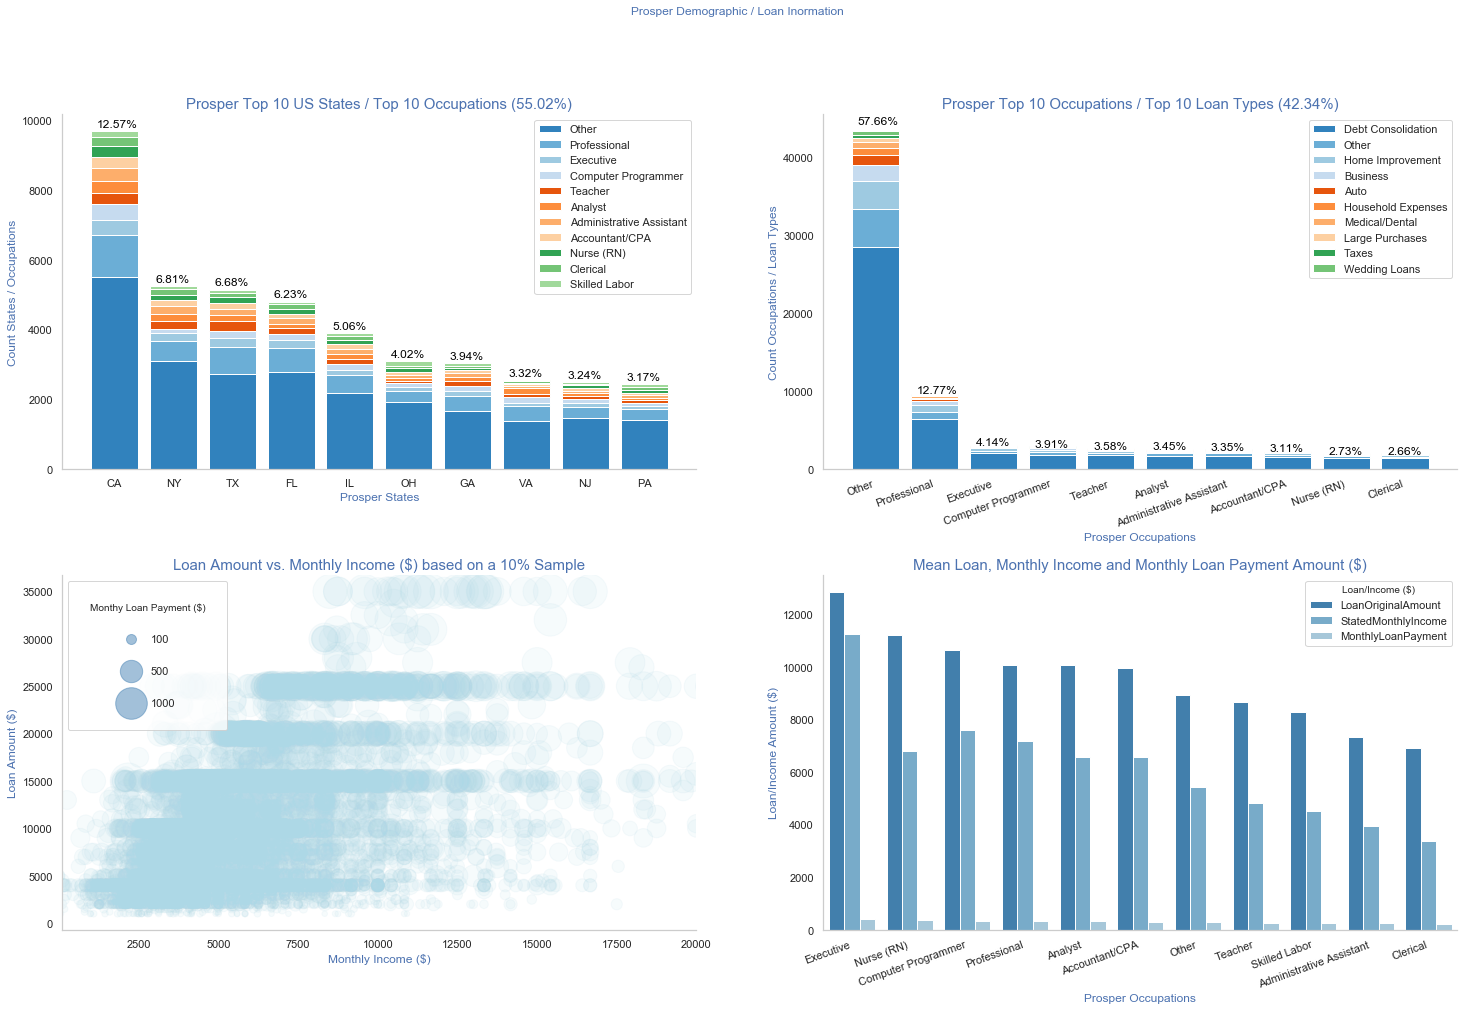

In [6]:
# common denominator
c_denominator = len(df)
name = "tab20c"
cmap = plt.get_cmap(name) 
colors = cmap.colors  # type: list

# create the main plot 
fig, ax = plt.subplots(2,2,figsize=(25,15))
plt.suptitle('Prosper Demographic / Loan Inormation', fontdict={'fontsize': 18}, color='b')
plt.subplots_adjust(hspace = 0.3)

######  upper left  #############################################
ul = ax[0,0]

# state
cat1_order =  sequence_state[:10]
# Occ
#cat2_order =  np.flip(sequence_occ) 
cat2_order =  sequence_occ
# HomeOwner
cat3_order =  sequence_state[:10]

# first iteration build occ
baselines = np.zeros(len(cat1_order))

#build "vertical" by vertical the stacekd plot
for i in range(len(cat2_order)):
    # isolate the counts of the first category,
    cat2 = cat2_order[i]
    inner_counts = df[df['Occupation_Condensed'] == cat2]['StateCondensed'].value_counts(normalize=False)
    # then plot those counts on top of the accumulated baseline
    ul.bar(x = np.arange(len(cat1_order)), height = inner_counts[cat1_order],
            bottom = baselines , color=colors[i])
      #removing top and right borders
    ul.spines['top'].set_visible(False)
    ul.spines['right'].set_visible(False)
    ul.grid(False)
    baselines += inner_counts[cat1_order]

total_counts_num = df['StateCondensed'].value_counts(normalize=False)
total_counts_perc = df['StateCondensed'].value_counts(normalize=True)

# text annotations
for i in range(len(cat1_order)):
    y = str(format(total_counts_perc[i]*100 ,'.2f')) + '%'
    ul .text(i-0.3, total_counts_num[cat1_order[i]]+200, y, va = 'center', color='black', fontdict={'fontsize': 12});

    
baselines = np.zeros(len(cat1_order))  
ul.set_xticks(np.arange(len(cat1_order)))
ul.set_xticklabels(cat1_order);
ul.legend(cat2_order);
topn_total_perc = str(format((1 - total_counts_perc['Other']) * 100, '.2f')) + '%'
ul.set_title('Prosper Top 10 US States / Top 10 Occupations (' + topn_total_perc +')', fontdict={'fontsize': 15}, color='b');
ul.set_xlabel('Prosper States', fontdict={'fontsize': 12}, color='b');
ul.set_ylabel('Count States / Occupations', fontdict={'fontsize': 12}, color='b');


######  upper right  #############################################
ur = ax[0,1]

# Occupations
cat1_order =  sequence_occ[:10]
# Listings
cat2_order =  sequence_li 

# first iteration build occ
baselines = np.zeros(len(cat1_order))

#build "vertical" by vertical the stacekd plot
for i in range(len(cat2_order)):
    # isolate the counts of the first category,
    cat2 = cat2_order[i]
    inner_counts = df[df['Listing_Cat_Condensed'] == cat2]['Occupation_Condensed'].value_counts(normalize=False)
    # then plot those counts on top of the accumulated baseline
    ur.bar(x = np.arange(len(cat1_order)), height = inner_counts[cat1_order],
            bottom = baselines , color=colors[i])
      #removing top and right borders
    ur.spines['top'].set_visible(False)
    ur.spines['right'].set_visible(False)
    ur.grid(False)
    baselines += inner_counts[cat1_order]

total_counts_num = df['Occupation_Condensed'].value_counts(normalize=False)
total_counts_perc = df['Occupation_Condensed'].value_counts(normalize=True)

# text annotations
for i in range(len(cat1_order)):
    y = str(format(total_counts_perc[i]*100 ,'.2f')) + '%'
    ur.text(i-0.3, total_counts_num[cat1_order[i]]+200, y, va = 'center', color='black', fontdict={'fontsize': 12});

    
baselines = np.zeros(len(cat1_order))  
ur.set_xticks(np.arange(len(cat1_order)))
ur.set_xticklabels(cat1_order, rotation = 20, ha='right');
ur.legend(cat2_order);
topn_total_perc = str(format((1 - total_counts_perc['Other']) * 100, '.2f')) + '%'
ur.set_title('Prosper Top 10 Occupations / Top 10 Loan Types (' + topn_total_perc +')', fontdict={'fontsize': 15}, color='b');
ur.set_xlabel('Prosper Occupations', fontdict={'fontsize': 12}, color='b');
ur.set_ylabel('Count Occupations / Loan Types', fontdict={'fontsize': 12}, color='b');


##################################################################
######  Lower left  #############################################
lf = ax[1,0]

lf.scatter(data = mv, x = 'StatedMonthlyIncome', y = 'LoanOriginalAmount', s = 'MonthlyLoanPayment', alpha = .1, color='lightblue')
lf.set_xlim(100,20000)
# dummy series for adding legend
sizes = [100,500, 1000 ]
base_color = sb.color_palette()[0]
legend_obj = []
# make legend
for s in sizes:
    legend_obj.append(lf.scatter([], [], s = s, alpha = .5 , color = 'steelblue'))    #color = base_color
lf.legend(legend_obj, sizes, title='Monthy Loan Payment ($)', loc='upper left',
          labelspacing=2, borderpad=2);
lf.spines['top'].set_visible(False)
lf.spines['right'].set_visible(False)
lf.grid(False)
lf.set_title('Loan Amount vs. Monthly Income ($) based on a 10% Sample', fontdict={'fontsize': 15}, color='b');
lf.set_xlabel('Monthly Income ($)', fontdict={'fontsize': 12}, color='b');
lf.set_ylabel('Loan Amount ($)', fontdict={'fontsize': 12}, color='b');


##################################################################
######  Lower right  #############################################

lr = ax[1,1]
#mv_m = mv.groupby('Occupation')['LoanOriginalAmount', 'StatedMonthlyIncome', 'MonthlyLoanPayment'].mean().reset_index()
#mv_m = mv_m[df_m['Occupation'].isin(sequence_occ)]
#mv_m['Occupation'] = df_m['Occupation'].astype('str')

mv_m = df.groupby('Occupation_Condensed')['LoanOriginalAmount', 'StatedMonthlyIncome', 'MonthlyLoanPayment'].mean().reset_index()
#mv_m = mv_m[mv_m['Occupation_Condensed'].isin(sequence_occ)]
mv_m['Occupation_Condensed'] = mv_m['Occupation_Condensed'].astype('str')

mv_m.sort_values('LoanOriginalAmount', ascending=False, inplace=True)

# bring to tidy format 
tidy = mv_m.melt(id_vars='Occupation_Condensed').rename(columns=str.title)
sb.barplot(x='Occupation_Condensed', y='Value', hue='Variable', data=tidy,  palette = colors)
lr.set_xticklabels(mv_m['Occupation_Condensed'], rotation = 20, ha='right');

lr.legend(title='Loan/Income ($)');
lr.spines['top'].set_visible(False)
lr.spines['right'].set_visible(False)
lr.grid(False)
lr.set_title('Mean Loan, Monthly Income and Monthly Loan Payment Amount ($)', fontdict={'fontsize': 15}, color='b');
lr.set_xlabel('Prosper Occupations', fontdict={'fontsize': 12}, color='b');
lr.set_ylabel('Loan/Income Amount ($)', fontdict={'fontsize': 12}, color='b');

## Why is Prosper used?

Let's figure out why borrowers are using prosper. Is it related to the speed of the process? This would mean the borrower get's the money fast. Another important aspect is, of course, the cost coming with the loan. Let's start with speed attribute which I call "Time to Money".

### Why is Prosper used - Time to Money?
We see that the respective time series is very volatile, bit looking to the 90 days rolling average, unleashes an interesting fact, that the Time to Money in days is close around 11 days.

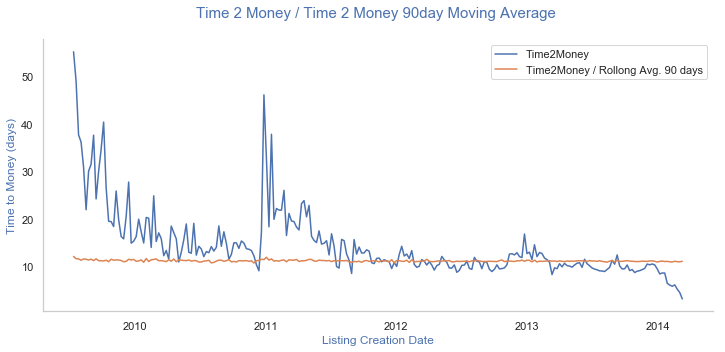

In [7]:
week_time2money_avg = df.groupby([pd.Grouper(key='ListingCreationDate', freq='W-MON')])['Time2Money', 'Time2Money_rolling'].mean().reset_index().sort_values('Time2Money')
plt.figure(figsize = [12, 5]) # larger figure size for subplots
ax = sb.lineplot(week_time2money_avg.ListingCreationDate, week_time2money_avg.Time2Money, label='Time2Money')
ax = sb.lineplot(week_time2money_avg.ListingCreationDate, week_time2money_avg.Time2Money_rolling, label='Time2Money / Rollong Avg. 90 days')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(False)
ax.set_title('Time 2 Money / Time 2 Money 90day Moving Average \n', fontdict={'fontsize': 15}, color='b');
ax.set_xlabel('Listing Creation Date', fontdict={'fontsize': 12}, color='b');
ax.set_ylabel('Time to Money (days)', fontdict={'fontsize': 12}, color='b');

### Why is Prosper used  Time to Money cont.? 

Let's review id there is a difference by Occupation. As the data is very fragmented, we do the analysis based on the top 10 occupations. We will see that the values do not differ a lot by ten occupations. As well as in comparison to the mean Time to Money (appr. 11days) and the mean Loan Amount(appr. 9300$) over all occupations. This means the speed of the listing process is not significantly differing. If the Time to Money attribute is a factor for Borrowers to use Prosper can't be finally proofed as we would need to compare it with, e.g. processing times of traditional banks.

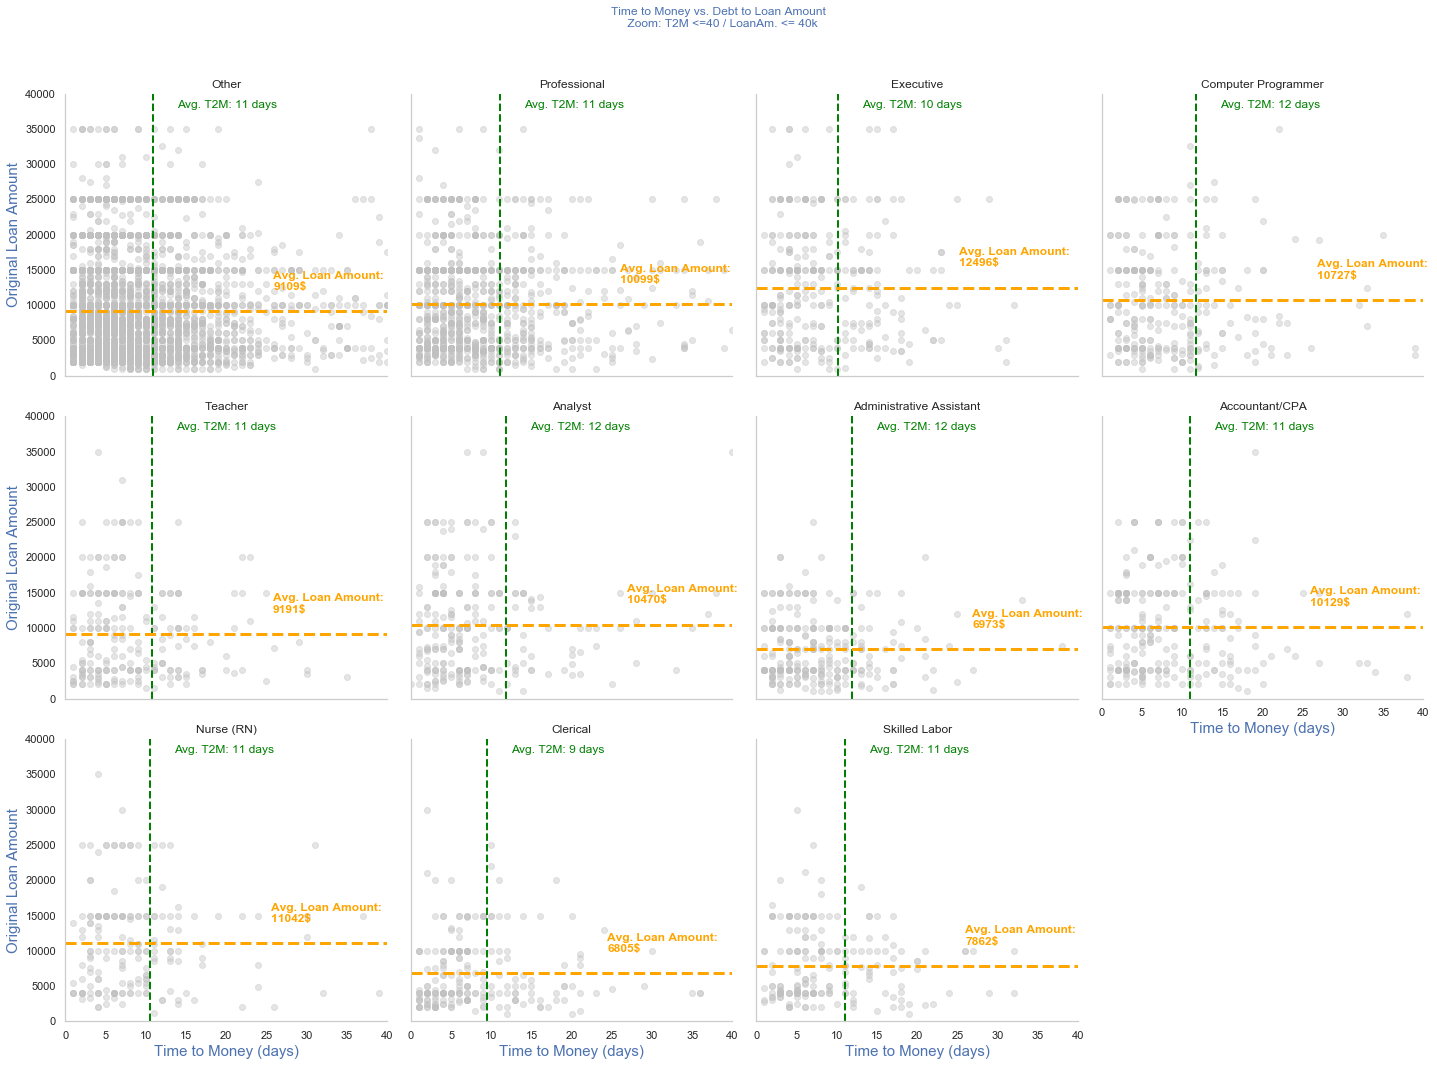

In [8]:
## functions
def vertical_mean_line(x, **kwargs):
    plt.axvline(x.mean(), color='green', linestyle='dashed', linewidth=2)
    
def horizontal_mean_line(x, **kwargs):
    plt.axhline(x.mean(), color='orange', linestyle='dashed', linewidth=3) 

def annotations(x,y, **kwargs):
    avg_days = '{:0.0f} days'.format(x.mean())
    plt.text(x.mean()+3, 38000, 'Avg. T2M: ' + avg_days , color='green', fontdict={'fontsize': 12});
    avg_amount = '{:0.0f}$'.format(y.mean())
    plt.text(x.mean()+15, y.mean()+ 3000, 'Avg. Loan Amount: \n' + avg_amount , color='orange', fontdict={'fontsize': 12, 'weight': 'heavy'});

# main plot   
g = sb.FacetGrid(data = mv, col = 'Occupation_Condensed', col_wrap = 4, size = 5, sharex=True, sharey=True, despine=True)
g.map(plt.scatter, 'Time2Money','LoanOriginalAmount', alpha = .4, color='silver');
g.set(xlim=(0,40))
g.set(ylim=(0,40000))
g.map(vertical_mean_line,'Time2Money' );
g.map(horizontal_mean_line, 'LoanOriginalAmount');
g.map(annotations, 'Time2Money', 'LoanOriginalAmount');
g.set_titles('{col_name}');

for i in np.arange(g.axes.shape[0]):
    g.axes[i].grid(False)
    

    
g.axes[0].set_ylabel('Original Loan Amount', fontdict={'fontsize': 15}, color='b');
g.axes[4].set_ylabel('Original Loan Amount', fontdict={'fontsize': 15}, color='b');
g.axes[8].set_ylabel('Original Loan Amount', fontdict={'fontsize': 15}, color='b');

g.axes[7].set_xlabel('Time to Money (days)', fontdict={'fontsize': 15}, color='b');
g.axes[8].set_xlabel('Time to Money (days)', fontdict={'fontsize': 15}, color='b');
g.axes[9].set_xlabel('Time to Money (days)', fontdict={'fontsize': 15}, color='b');
g.axes[10].set_xlabel('Time to Money (days)', fontdict={'fontsize': 15}, color='b');

g.fig.suptitle('Time to Money vs. Debt to Loan Amount \n Zoom: T2M <=40 / LoanAm. <= 40k', fontdict={'fontsize': 18}, color='b');
g.fig.subplots_adjust(top=.9)

### Why is Prosper used - Annual Percentage Rate?

Let's review may be the most important fact for a borrower. The annual percentage rate (APR), which is a combination of interest rate and all fees, the borrower needs to pay.
We will see that Loan Amount vs the BorrowerAPR by Occupation is pretty much interesting. The mean APR and Loan are very close to each other. However, Computer Programmers get the best rates on average, 19,10%. Administrative Assistants get the worst rates, 25,59%. Interesting is the fact that loan amounts, e.g. 20k, seem to have primarily rates better than the average of the individual occupation group. See below the red arrow annotations in the other group (this pattern can also be seen in the other occupation groups).
If the rates are so useful to attract the borrowers would need to be analyzed in combination with other data, e.g. data from bank loans for similar purposes and runtimes. For me, the rates seem to be far high, especially in current times (and compared to Germany).

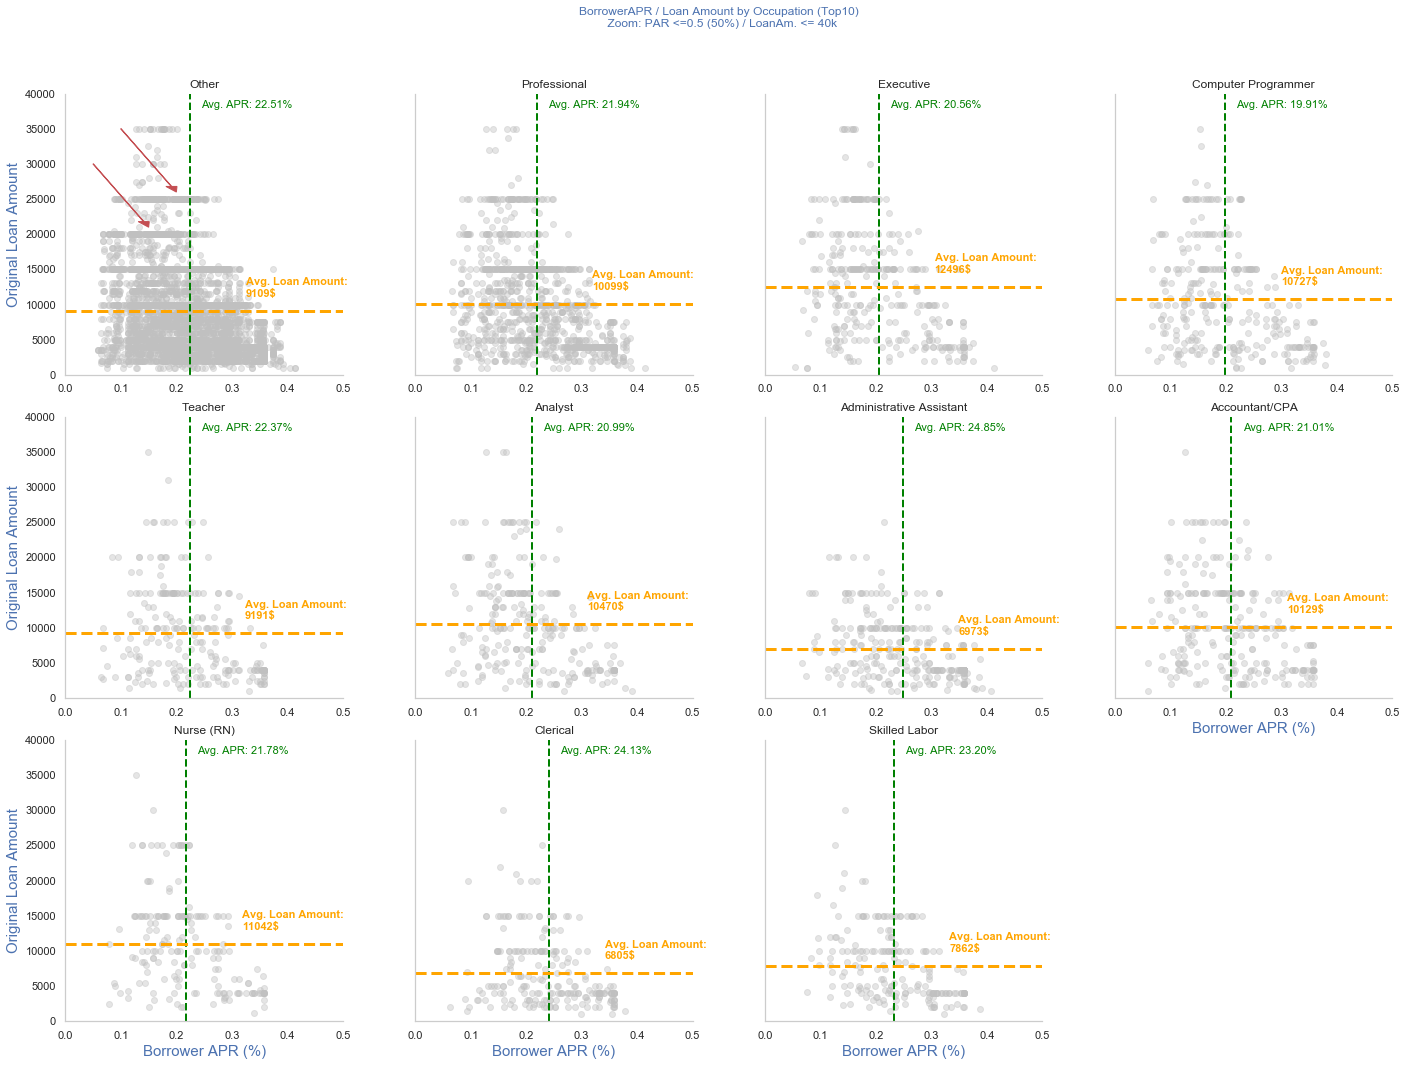

In [9]:
# functions
def vertical_mean_line(x, **kwargs):
    plt.axvline(x.mean(), color='green', linestyle='dashed', linewidth=2)
    
def horizontal_mean_line(x, **kwargs):
    plt.axhline(x.mean(), color='orange', linestyle='dashed', linewidth=3) 

def annotations(x,y, **kwargs):
    avg_perc = '{:0.2f}%'.format(x.mean()*100)
    plt.text(x.mean()+.02, 38000, 'Avg. APR: ' + avg_perc , color='green', fontdict={'fontsize': 11});
    avg_amount = '{:0.0f}$'.format(y.mean())
    plt.text(x.mean()+.1, y.mean()+ 2000, 'Avg. Loan Amount: \n' + avg_amount , color='orange', fontdict={'fontsize': 11, 'weight': 'heavy'});


# main plot   
g = sb.FacetGrid(data = mv, col = 'Occupation_Condensed', col_wrap = 4, size = 5, sharex=False)
g.map(plt.scatter, 'BorrowerAPR','LoanOriginalAmount', alpha = .4, color='silver');
g.map(vertical_mean_line, 'BorrowerAPR');
g.map(horizontal_mean_line, 'LoanOriginalAmount');
g.map(annotations, 'BorrowerAPR', 'LoanOriginalAmount');
g.set(xlim=(0,.5))
g.set(ylim=(0,40000))
g.set_titles('{col_name}');

for i in np.arange(g.axes.shape[0]):
    g.axes[i].grid(False)
    
    
g.axes[0].set_ylabel('Original Loan Amount', fontdict={'fontsize': 15}, color='b');
g.axes[4].set_ylabel('Original Loan Amount', fontdict={'fontsize': 15}, color='b');
g.axes[8].set_ylabel('Original Loan Amount', fontdict={'fontsize': 15}, color='b');
g.axes[7].set_xlabel('Borrower APR (%)', fontdict={'fontsize': 15}, color='b');
g.axes[8].set_xlabel('Borrower APR (%)', fontdict={'fontsize': 15}, color='b');
g.axes[9].set_xlabel('Borrower APR (%)', fontdict={'fontsize': 15}, color='b');
g.axes[10].set_xlabel('Borrower APR (%)', fontdict={'fontsize': 15}, color='b');

#g.axes[2].set_title('LoanMount vs. APR by Occupation (Top10) \n', fontsize=18,  color="b");

# special annot.
#arrow(x, y, dx, dy, **kwargs)[source]
g.axes[0].arrow(.1, 35000, .1, -9000, length_includes_head=True,head_width=.02, head_length=800, fc='r', ec='r');
g.axes[0].arrow(.05, 30000, .1, -9000, length_includes_head=True,head_width=.02, head_length=800, fc='r', ec='r');


g.fig.suptitle('BorrowerAPR / Loan Amount by Occupation (Top10) \n Zoom: PAR <=0.5 (50%) / LoanAm. <= 40k', fontdict={'fontsize': 18}, color='b');
g.fig.subplots_adjust(top=.9);


### What is influencing the rates?

Let's review how the prosper rate and so the Borrower APR is influenced. We nicely see that the Prosper Score is a mighty evaluation metric. We can see that the distribution of the Borrower APR is getting worse from High Risk (HR) to Excellent Rating (AA). Furthermore, we can see that the rates are increasing with higher indebtedness (DebtToIncomeRatio). At least slightly by decreasing Prosper Rating. Same for the estimated loss, it gets marginally higher by increasing indebtedness and in huge steps by the assignment to the Propsper Score. 

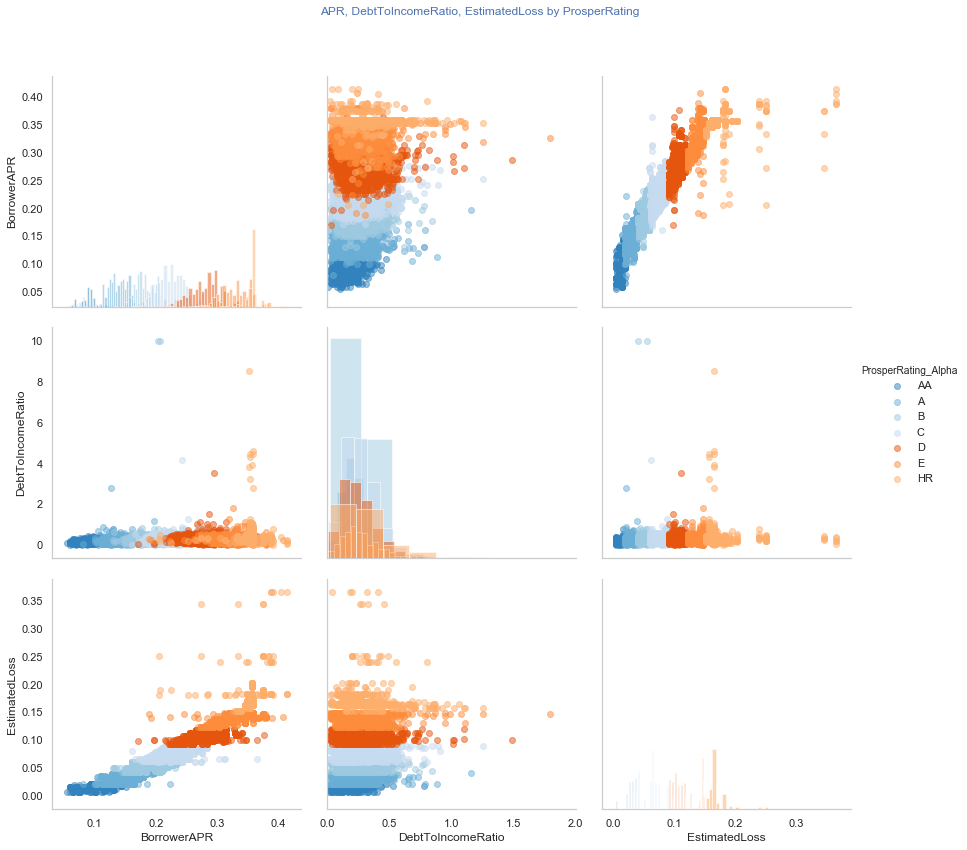

In [10]:
# attributes for metric variables 
variables = ["BorrowerAPR", "DebtToIncomeRatio", "EstimatedLoss"]
g = sb.PairGrid(data = mv, vars = variables, size = 4, hue="ProsperRating_Alpha", palette ='tab20c')
g = g.map_diag(plt.hist, bins = 40, alpha = .5);
g.map_offdiag(plt.scatter, alpha = .5);

for i in np.arange(g.axes.shape[0]):
    for j in np.arange(g.axes.shape[1]):
        g.axes[i,j].grid(False)
        
# let's improve some axis limits
g.axes[0,1].set_xlim(0,2)
g.add_legend();
g.fig.suptitle('APR, DebtToIncomeRatio, EstimatedLoss by ProsperRating ', fontdict={'fontsize': 18}, color='b');
g.fig.subplots_adjust(top=.9);
